## Goal

How have the win percentages for Detroit's major sports teams (Pistons, Red Wings, Tigers, and Lions) changed over the past 80 years using a 10-year sliding window?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from packaging.version import Version

### Load daset

In [5]:
datasets={
    'pistons':  'https://en.wikipedia.org/wiki/List_of_Detroit_Pistons_seasons',
    'redwings': 'https://en.wikipedia.org/wiki/List_of_Detroit_Red_Wings_seasons',
    'tiger':    'https://en.wikipedia.org/wiki/List_of_Detroit_Tigers_seasons',
    'lions':    'https://en.wikipedia.org/wiki/List_of_Detroit_Lions_seasons'
}

### Utils

In [6]:
def get_window_and_winratio(df, window=10, team='Pistons'):
    df['Window'] = (df['Year'] // window) * window
    if team == 'RedWings' or team == 'Lions':
        df = df.groupby('Window').agg({'Wins': 'sum', 'Losses': 'sum', 'Ties': 'sum'}).reset_index()
        df['WinRatio'] = (df['Wins'] + 0.5 * df['Ties']) / (df['Wins'] + df['Losses'] + df['Ties'])
    else:
        df = df.groupby('Window').agg({'Wins': 'sum', 'Losses': 'sum'}).reset_index()
        df['WinRatio'] = df['Wins'] / (df['Wins'] + df['Losses'])
    df.columns = [col + '_' + team if col != 'Window' else col for col in df.columns]
    return df

### Pistons

In [7]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

wiki_pistons = pd.read_html(datasets['pistons'])[1][1:]

pistons = pd.DataFrame()
pistons['Year'] = wiki_pistons['Team'].str[:4]
pistons[['Wins','Losses']] = wiki_pistons[['Wins','Losses']]
pistons = pistons[~(pistons['Year'].str.contains('Fort|Detr'))]
pistons[['Year', 'Wins', 'Losses']] = pistons[['Year', 'Wins', 'Losses']].astype(int)
pistons

,Year,Wins,Losses
1,1941,15,9
2,1942,17,6
3,1943,18,4
4,1944,25,5
5,1945,26,8
...,...,...,...
82,2020,20,52
83,2021,23,59
84,2022,17,65
85,2023,14,68


### RedWings

In [8]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

wiki_redwings = pd.read_html(datasets['redwings'])[2][1:]

redwings = pd.DataFrame()
redwings['Year'] = wiki_redwings['NHL season']['NHL season'].str[:4]
redwings[['GP', 'Wins','Losses', 'Ties', 'OT']] = wiki_redwings['Regular season[3][6][7][8]'][['GP','W','L','T','OT']]
redwings = redwings[~((redwings['Year'].str.contains('^Detr|^Tota')) |
                      (redwings['Wins'].str.contains('^—')) |
                      (redwings['Losses'].str.contains('^—')) |
                      (redwings['Ties'].str.contains('^—\[m\]')))]

redwings['OT'] = redwings['OT'].str.replace('\[k\]','', regex=True)
redwings['Ties'] = redwings['Ties'].apply(lambda x: 0 if x == '—' else x) # redwings.loc[redwings['Ties'] == '—', 'Ties'] = 0
redwings['OT']   = redwings['OT'].apply(lambda x: 0 if x == '—' else x)   # redwings.loc[redwings['OT'] == '—', 'OT'] = 0

redwings[['Year', 'Wins', 'Losses', 'Ties', 'OT']] = redwings[['Year', 'Wins', 'Losses', 'Ties', 'OT']].astype(int)
redwings['Ties'] = redwings['Ties'] + redwings['OT']
redwings = redwings[['Year', 'Wins', 'Losses', 'Ties']]
redwings

,Year,Wins,Losses,Ties
1,1926,12,28,4
2,1927,19,19,6
3,1928,19,16,9
4,1929,14,24,6
6,1930,16,21,7
...,...,...,...,...
97,2020,19,27,10
98,2021,32,40,10
99,2022,35,37,10
100,2023,41,32,9


### Tiger

In [9]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

wiki_tiger = pd.read_html(datasets['tiger'])[1]

tiger = pd.DataFrame()
tiger['Year'] = wiki_tiger['Season']
tiger[['Wins','Losses']] = wiki_tiger[['Wins','Losses']]

tiger = tiger[~(tiger['Year'].str.contains('Total'))]
tiger[['Year', 'Wins', 'Losses']] = tiger[['Year', 'Wins', 'Losses']].astype(int)

tiger

,Year,Wins,Losses
0,1901,74,61
1,1902,52,83
2,1903,65,71
3,1904,62,90
4,1905,79,74
...,...,...,...
120,2020,23,35
121,2021,77,85
122,2022,66,96
123,2023,78,84


### Lions

In [10]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

pd_version = Version(pd.__version__)

wiki_lions = pd.read_html(datasets['lions'])[1]

lions = pd.DataFrame()
lions['Year'] = wiki_lions['Season'][['Season']]
if pd_version <=  Version("1.5.2"):
    lions[['Wins','Losses', 'Ties']] = wiki_lions['Regular season'][['.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}W', 'L', 'T']]
else:
    lions[['Wins','Losses', 'Ties']] = wiki_lions['Regular season'][['W', 'L', 'T']]
lions = lions[~(lions['Year'].str.startswith('Totals'))]
lions[['Year', 'Wins', 'Losses', 'Ties']] = lions[['Year', 'Wins', 'Losses', 'Ties']].astype(int)

lions

,Year,Wins,Losses,Ties
0,1928,9,3,2
1,1929,12,2,1
2,1930,5,6,3
3,1931,11,3,0
4,1932,6,2,4
...,...,...,...,...
92,2020,5,11,0
93,2021,3,13,1
94,2022,9,8,0
95,2023,12,5,0


### Aggregate data using a 10-year sliding window

In [11]:
window=10 ## change window

pistons_agg = get_window_and_winratio(pistons, window=window, team='Pistons')
redwings_agg = get_window_and_winratio(redwings, window=window, team='RedWings')
tiger_agg = get_window_and_winratio(tiger, window=window, team='Tiger')
lions_agg = get_window_and_winratio(lions, window=window, team='Lions')

df = pd.merge(pistons_agg, redwings_agg, on='Window').merge(tiger_agg, on='Window').merge(lions_agg, on='Window')

df.set_index('Window', inplace=True)
df

,Wins_Pistons,Losses_Pistons,WinRatio_Pistons,Wins_RedWings,Losses_RedWings,Ties_RedWings,WinRatio_RedWings,Wins_Tiger,Losses_Tiger,WinRatio_Tiger,Wins_Lions,Losses_Lions,Ties_Lions,WinRatio_Lions
Window,,,,,,,,,,,,,,
1940,228,137,0.624658,265,190,91,0.568681,834,705,0.541910,35,71,4,0.336364
1950,342,368,0.481690,351,218,131,0.595000,738,802,0.479221,68,48,4,0.583333
1960,314,492,0.389578,308,292,116,0.511173,882,729,0.547486,66,61,11,0.518116
1970,367,453,0.447561,267,410,115,0.409722,789,820,0.490367,66,75,3,0.468750
1980,466,354,0.568293,273,410,117,0.414375,839,727,0.535760,61,90,1,0.404605
1990,394,394,0.500000,438,248,100,0.620865,702,852,0.451737,79,81,0,0.493750
2000,482,338,0.587805,395,163,98,0.676829,729,891,0.450000,42,118,0,0.262500
2010,326,462,0.413706,354,316,105,0.524516,782,835,0.483612,72,87,1,0.453125
2020,118,282,0.295000,166,171,47,0.493490,330,376,0.467422,44,39,1,0.529762


In [16]:
## check tiger aggregation with wiki data

tigercheck = get_window_and_winratio(tiger, window=10, team='').rename(columns={'Window':'Decade'}).set_index('Decade')
tigercheck.columns = [col.strip('_') for col in tigercheck.columns]

wikidec = pd.read_html(datasets['tiger'])[2]
wikidec['Decade'] = wikidec['Decade'].str.replace('s', '')
wikidec = wikidec[:-1]
wikidec = wikidec[['Decade', 'Wins','Losses']]
wikidec[['Decade', 'Wins', 'Losses']] = wikidec[['Decade', 'Wins', 'Losses']].astype(int)
wikidec.set_index('Decade', inplace=True)

wikidec[['Wins','Losses']] == tigercheck[['Wins','Losses']] 
pd.merge(tigercheck, wikidec, on='Decade')
tiger[tiger['Window'] == 2020]

# note: test passed for all windows except for 2020,
#       because wikidec does not count wins/losses for 2024

,Year,Wins,Losses,Window
120,2020,23,35,2020
121,2021,77,85,2020
122,2022,66,96,2020
123,2023,78,84,2020
124,2024,86,76,2020


### Plot Detroit's major teams trends

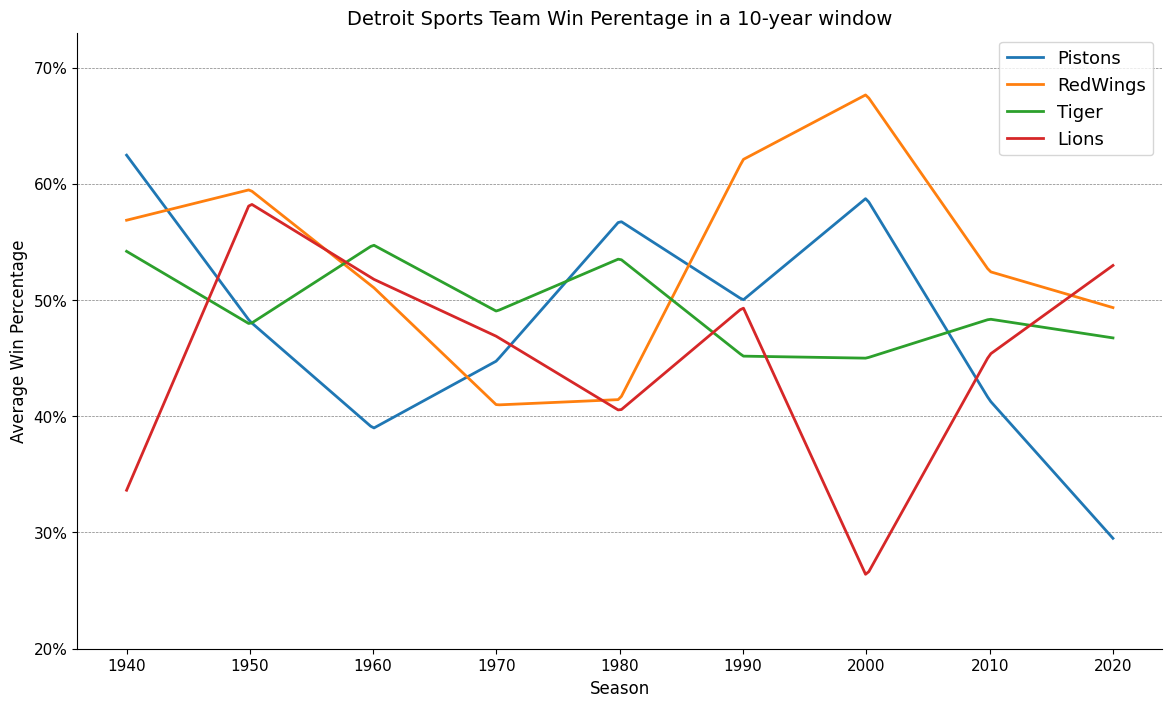

In [ ]:
from matplotlib.ticker import FixedLocator, FuncFormatter
from scipy.interpolate import make_interp_spline

# Teams and their win ratio columns 
teams = {'Pistons': 'WinRatio_Pistons', 
         'RedWings': 'WinRatio_RedWings', 
         'Tiger': 'WinRatio_Tiger', 
         'Lions': 'WinRatio_Lions'}

# Generate new x values for smooth curves
x_new = np.linspace(df.index.min(), df.index.max(), 300)

# Create big4 smooth curves and plot
# nb: it's better to smooth lines when you have several data points 
k=1 ## k>=2 to smooth lines
fig, ax = plt.subplots(figsize=(14, 8))
for team, col in teams.items():
    spl = make_interp_spline(df.index, df[col], k=k)
    y_smooth = spl(x_new)
    plt.plot(x_new, y_smooth, label=team, linewidth=2)

plt.yticks(size=11)
plt.xticks(size=11)
plt.xlabel('Season', size = 12)
plt.ylabel('Average Win Percentage', size = 12)
plt.title('Detroit Sports Team Win Perentage in a '+str(window)+'-year window', size = 14)

yticks = np.arange(0.2, 0.8, 0.1) 
ax.yaxis.set_major_locator(FixedLocator(yticks)) 
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(round(y * 100))}%')) 
ax.set_ylim(0.20, 0.73)

ax.yaxis.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='best', fontsize=13)

# if k>=2:
#     plt.savefig('detroit-avg-win-smoothed.png')
# else:
#     plt.savefig('detroit-avg-win.png')
    
plt.show()

### Discussion

The plot answers the question of how the winning percentages of the four major Detroit sports teams (Pistons, Red Wings, Tigers and Lions) have changed over the last 80 years. Wikipedia was scraped for data on wins, losses and ties by season for each team. For a fair comparison across sports, we computed the winning percentage as the number of wins divided by the total number of games played (i.e. wins plus ties plus losses). We assumed that a tie is 1/2 of a win, so the winning percentage was computed as $\frac{(wins + 0.5×ties)}{(wins+ties+losses)}$. For Pistons and Tigers (basketball and baseball) ties do not occur so the winning percentage was simply computed as $\frac{(wins)}{(wins+losses)}$. A 10 year moving average was plotted to identify trends in the team’s win percentages.


The Pistons saw high performance in 1940, 1980, and 2000, followed by periods of decline. The Red Wings experienced a notable rise from 1980 to 2000, with a subsequent downward trend. The Tigers' win percentage remains relatively stable around 50% with minor fluctuations with lowest performance between 1990 and 2000. The Lions show an up and down trend, starting low, peaking in 1950, 1990 and 2010 and then declining again.
